In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Proposed Model**

In [2]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [4]:

image_directory = "/content/drive/MyDrive/CSE 438/Segmented Liver with Tumor3/"
mask_directory = "/content/drive/MyDrive/CSE 438/Tumor liver3/"

SIZE = 256
image_dataset = []  
mask_dataset = []  

images = os.listdir(image_directory)
masks = os.listdir(mask_directory)

a=masks[0].split('-')
masks2=[]
for i in range (0,len(images)):
      a=images[i].split('-')
      x='segmentaions-'+a[1]
      masks2.append(x)
masks=masks2

for i, image_name in enumerate(images):    
        image = cv2.imread(image_directory+image_name, 0)
        image = image[188:1212,852:1748]
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))


for i, image_name in enumerate(masks):    
        image = cv2.imread(mask_directory+image_name, 0)
        image = image[188:1212,852:1748]
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


In [5]:
#%%
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)

mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

print(image_dataset.shape)
print(mask_dataset.shape)

(2361, 256, 256, 1)
(2361, 256, 256, 1)


In [6]:
#%%
from sklearn.model_selection import train_test_split
X_train, test_x, y_train, test_y = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.10, random_state = 0)
print(X_train.shape)
print(y_train.shape)

(1911, 256, 256, 1)
(1911, 256, 256, 1)


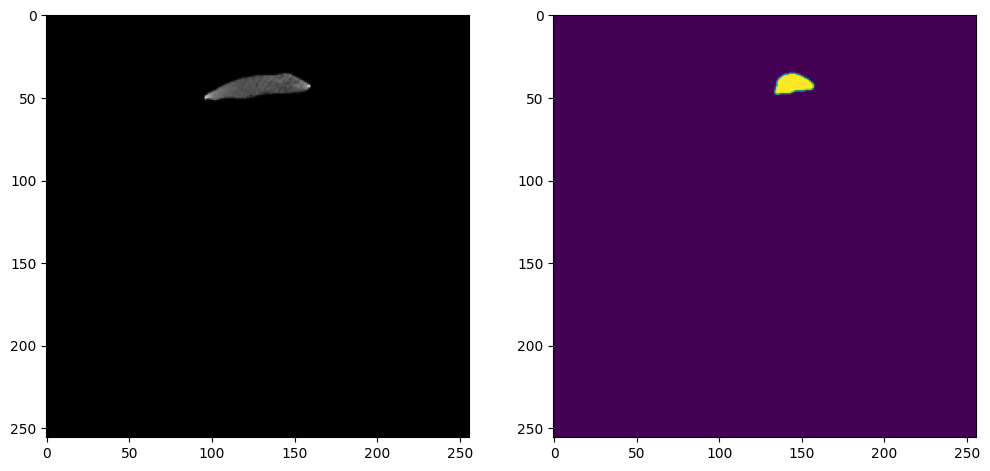

In [ ]:
#%%
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)))
plt.show()

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.metrics.binary_crossentropy (y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU, Accuracy

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)  
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)
    
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    #Expansive path 
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
     
    u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.1)(c11)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coeff])
    model.summary()
    return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = '/content/drive/MyDrive/CSE 438/2_Best_Tumor_Det.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(patience=5, monitor='val_loss', mode='min')

In [ ]:
#%%
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]


model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

rec = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100,
                    callbacks=[checkpoint,early_stopping], 
                    validation_data=(X_test, y_test), 
                    shuffle=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
#%%
#model.save('/content/drive/MyDrive/CSE 438/Tumor_Det.hdf5')
#from tensorflow.keras.models import load_model
#model=load_model('/content/drive/MyDrive/CSE 438/2_Best_Tumor_Det.hdf5',custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

8/8 [==============================] - 1s 66ms/step - loss: 0.0906 - dice_coeff: 0.9217
Accuracy =  92.17437505722046 %


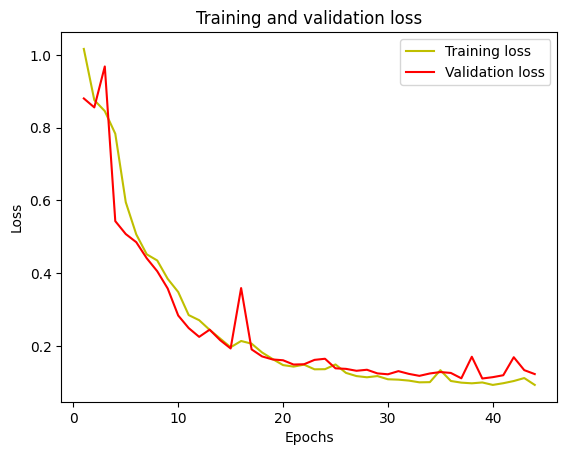

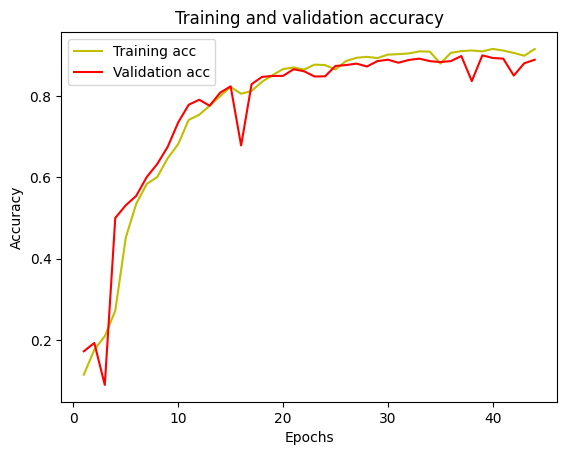

In [ ]:
#%%
_, acc = model.evaluate(test_x, test_y)
print("Accuracy = ", (acc * 100.0), "%")

loss = rec.history['loss']
val_loss = rec.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = rec.history['dice_coeff']
val_acc = rec.history['val_dice_coeff']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#%%
print("\nTraining Accuracy\n")

y_pred=model.predict(X_train)
y_pred_thresholded = y_pred > 0.6

"""IoU Score"""
intersection = np.logical_and(y_train, y_pred_thresholded)
union = np.logical_or(y_train, y_pred_thresholded)
iou_score_tr = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_tr)

"""Dice Coefficient"""
y_true_f = y_train.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_tr = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_tr)


Training Accuracy

60/60 [==============================] - 4s 64ms/step
IoU socre is:  0.840926651844573
Dice coefficient is:  0.9322110616225722


In [ ]:
#%%
print("\nValidation Accuracy\n")

y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.6

"""IoU Score"""
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score_val = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_val)

"""Dice Coefficient"""
y_true_f = y_test.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_v = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_v)


Validation Accuracy

7/7 [==============================] - 0s 77ms/step
IoU socre is:  0.8045158147619206
Dice coefficient is:  0.9103148587084762


In [ ]:
#%%
print("\nTesting Accuracy\n")

y_pred=model.predict(test_x)
y_pred_thresholded = y_pred > 0.6

"""IoU Score"""
intersection = np.logical_and(test_y, y_pred_thresholded)
union = np.logical_or(test_y, y_pred_thresholded)
iou_score_tst = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_tst)

"""Dice Coefficient"""
y_true_f = test_y.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_tst = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_tst)


Testing Accuracy

8/8 [==============================] - 0s 61ms/step
IoU socre is:  0.8272092581021977
Dice coefficient is:  0.9242951637939094


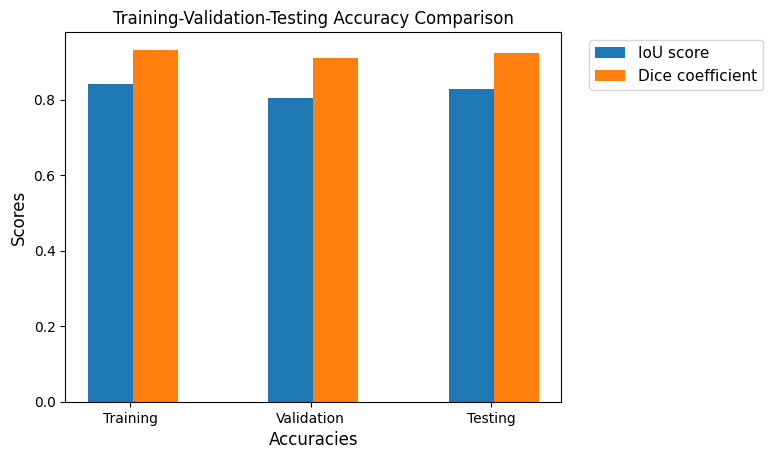

In [ ]:
iou_list=[]
dice_list=[]

iou_list.append(iou_score_tr)
iou_list.append(iou_score_val)
iou_list.append(iou_score_tst)

dice_list.append(dice_tr)
dice_list.append(dice_v)
dice_list.append(dice_tst)

X = ['Training','Validation','Testing']
X_axis = np.arange(len(X))


plt.bar(X_axis + 0.00, iou_list, width = 0.25, label = 'IoU score')
plt.bar(X_axis + 0.25, dice_list, width = 0.25, label = 'Dice coefficient')
 
plt.xticks(X_axis+.11, X, )
plt.xlabel("Accuracies",fontsize=12)
plt.ylabel("Scores",fontsize=12)
plt.title("Training-Validation-Testing Accuracy Comparison")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=11, title_fontsize=10)
plt.show()

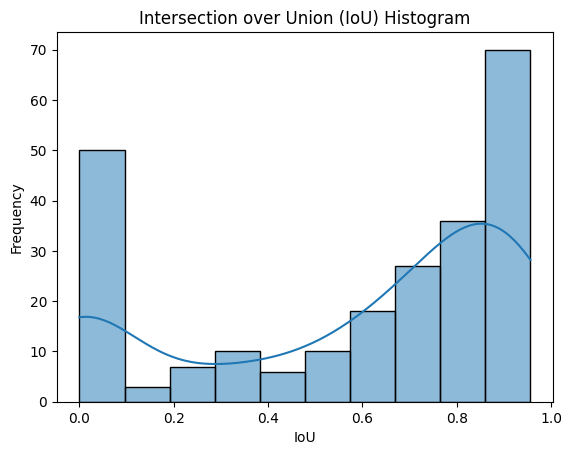

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def generate_iou_histogram(y_true_masks, y_pred_masks, num_bins=10):
    iou_scores = []
    for i in range(len(y_true_masks)):
        iou = calculate_iou(y_true_masks[i], y_pred_masks[i])
        iou_scores.append(iou)

    sns.histplot(iou_scores, bins=num_bins, kde=True)
    plt.xlabel('IoU')
    plt.ylabel('Frequency')
    plt.title('Intersection over Union (IoU) Histogram')
    plt.show()

y_true_masks = test_y
y_pred_masks = y_pred_thresholded

generate_iou_histogram(y_true_masks, y_pred_masks, num_bins=10)


1/1 [==============================] - 0s 20ms/step


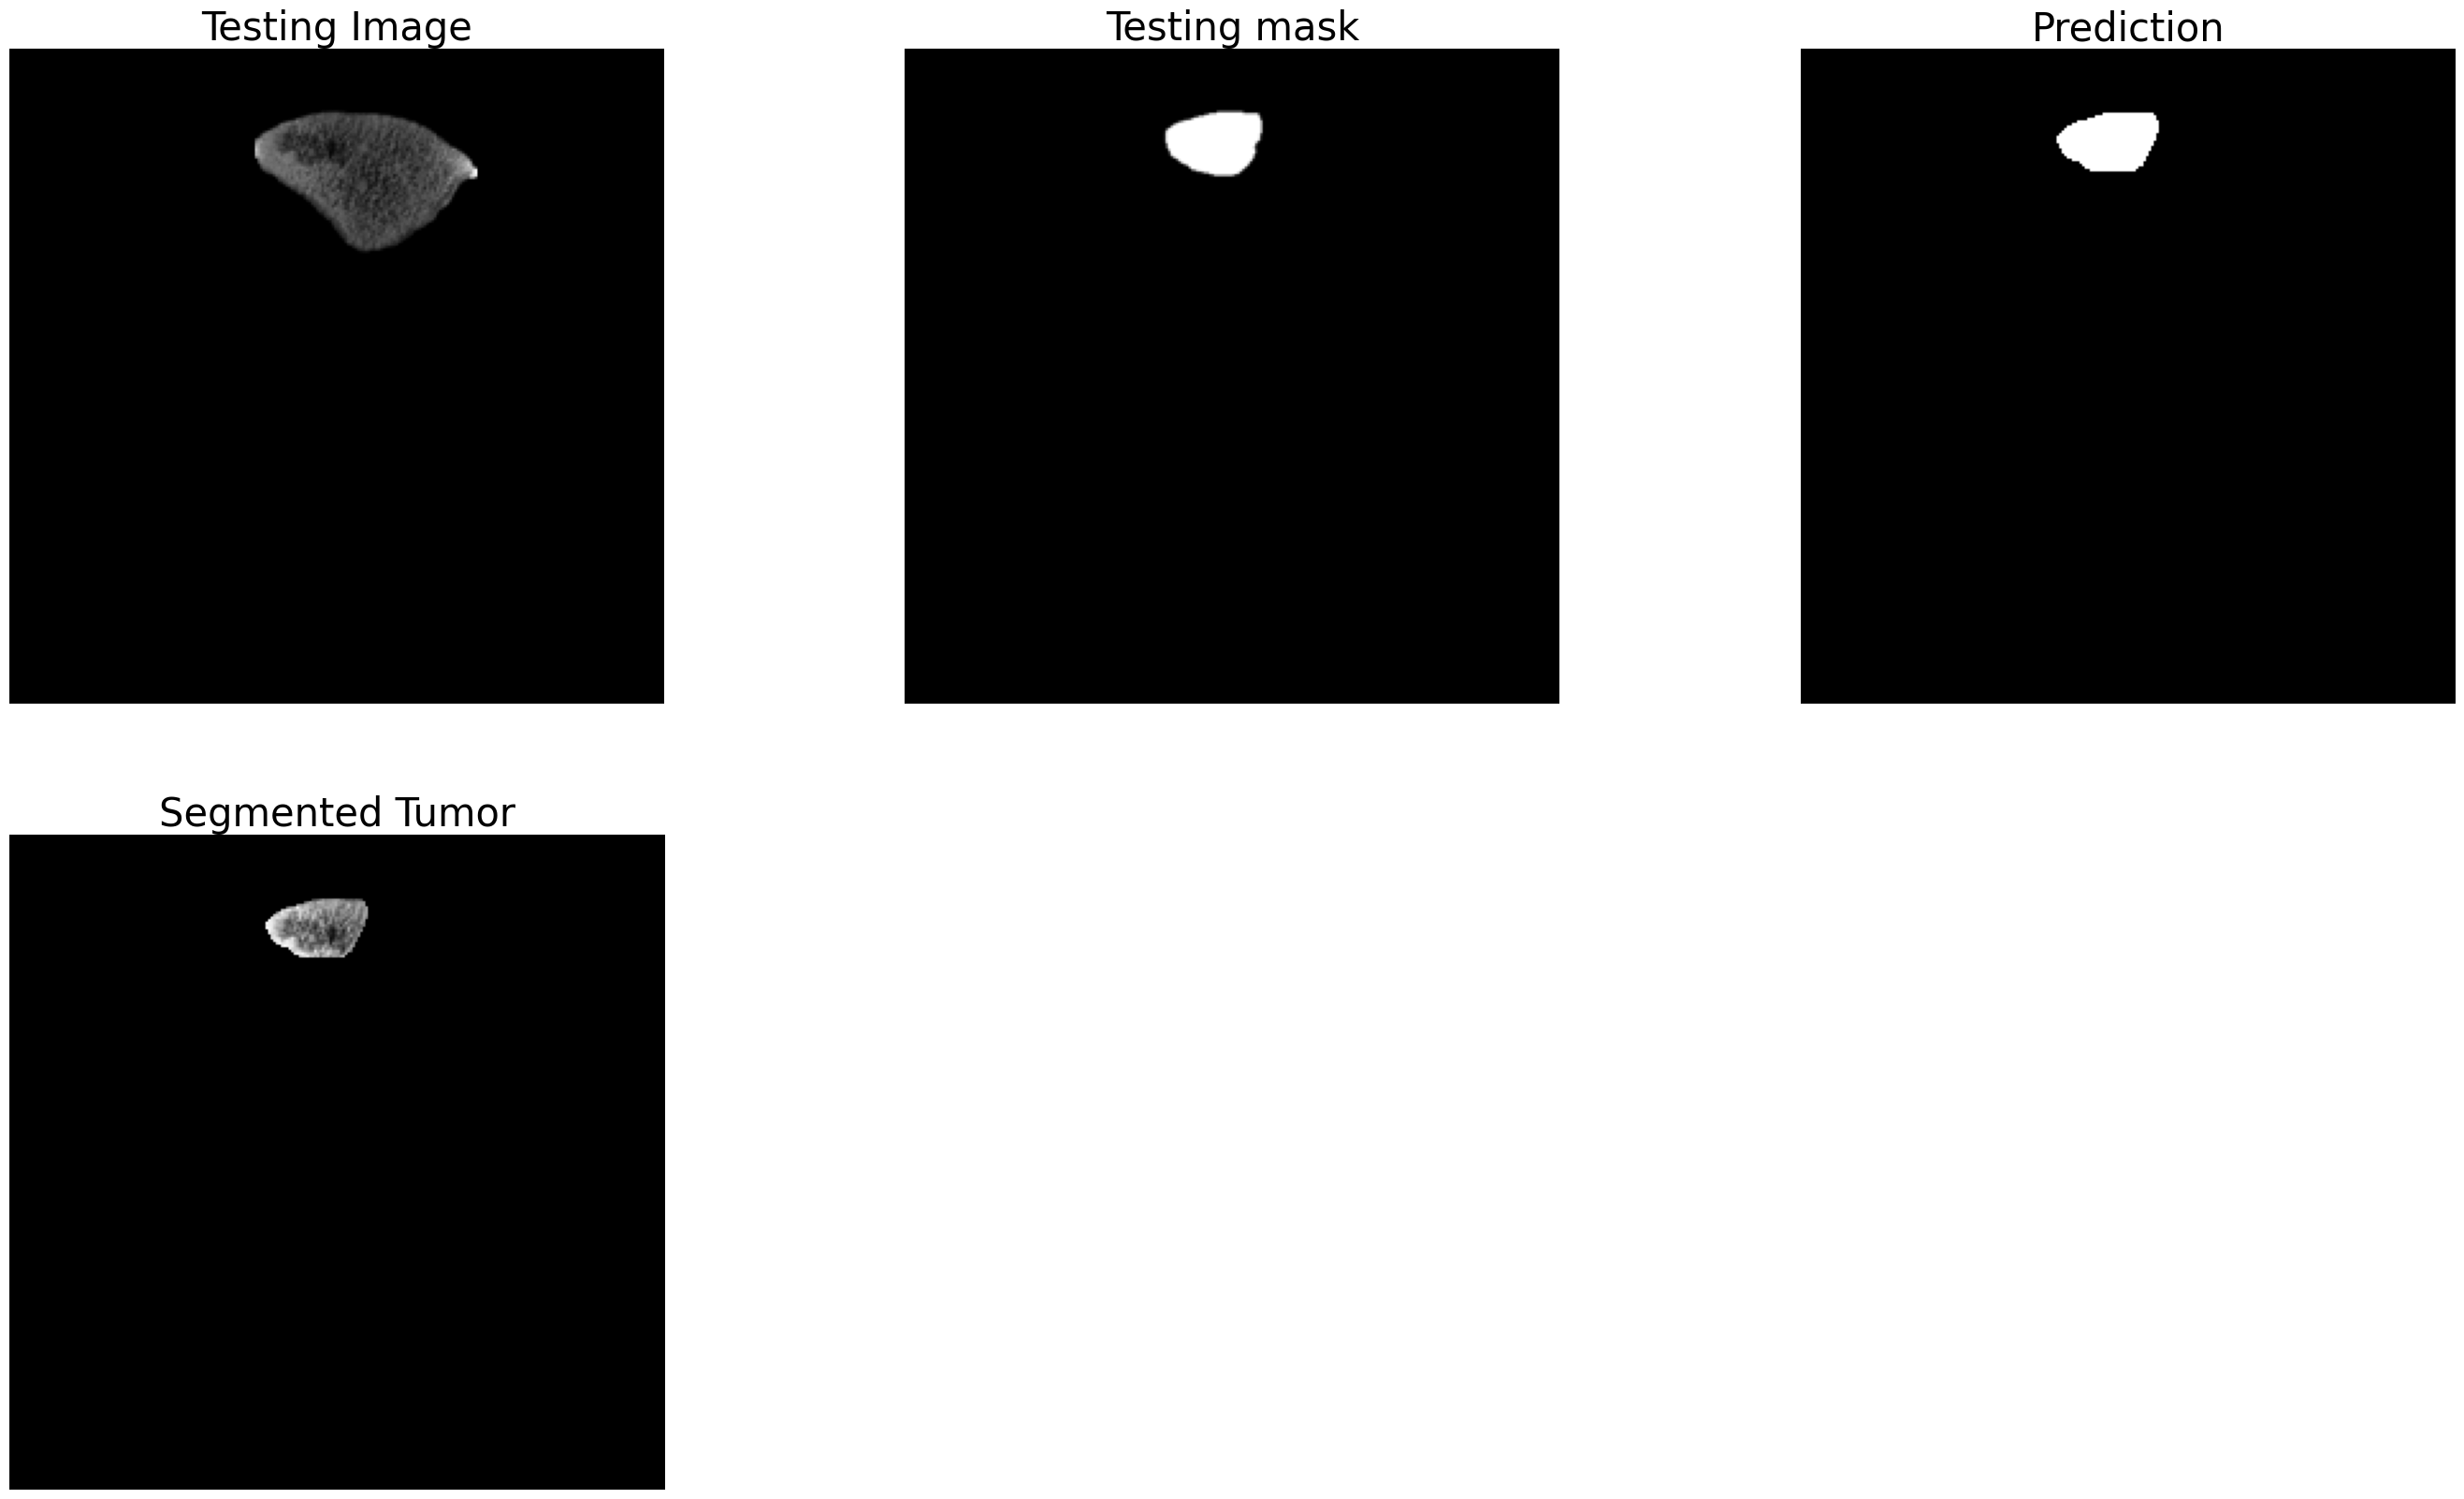

In [ ]:
#%%
import random
import cv2
import numpy as np

test_img_number = random.randint(0, len(test_x))
test_img = test_x[test_img_number]
ground_truth=test_y[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5)


plt.figure(figsize=(35, 20))
plt.subplot(231)
plt.axis('off')
plt.title('Testing Image',fontsize=30)
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.axis('off')
plt.title('Testing mask',fontsize=30)
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.axis('off')
plt.title('Prediction',fontsize=30)
plt.imshow(prediction, cmap='gray')

image = test_img
mask = prediction
mask = mask.astype(np.uint8)
masked = cv2.bitwise_and(image, image, mask=mask)
plt.subplot(234)
plt.axis('off')
plt.title('Segmented Tumor',fontsize=30)
plt.imshow(masked, cmap='gray')


1/1 [==============================] - 0s 21ms/step


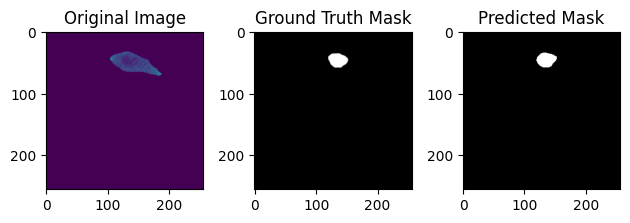

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_error_analysis(image, ground_truth_mask, predicted_mask):
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    # Plot the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.tight_layout()
    plt.show()


import random
import cv2
import numpy as np

test_img_number = random.randint(0, len(test_x))
test_img = test_x[test_img_number]
ground_truth=test_y[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6)

# Assuming you have your images, ground truth masks, and predicted masks as NumPy arrays
images = test_img  # Array of images
ground_truth_masks = ground_truth  # Array of ground truth masks
predicted_masks = prediction  # Array of predicted masks

# Generate error analysis plots
plot_error_analysis(images, ground_truth_masks, predicted_masks)


1/1 [==============================] - 0s 20ms/step


<ipython-input-64-cf4f45e4b6f0>:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot()


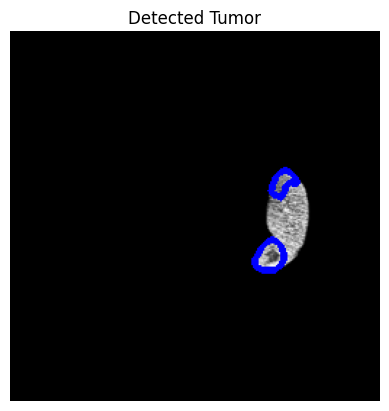

In [ ]:
#%%
import numpy as np
import cv2
import random
import numpy as np

image_directory = "/content/drive/MyDrive/CSE 438/Segmented Liver with Tumor/"
mask_directory = "/content/drive/MyDrive/CSE 438/Tumor liver/"

images = os.listdir(image_directory)
masks = os.listdir(mask_directory)

image_number = random.randint(0, len(images))
image_name = images[image_number]
mask_name = masks[image_number]

test_img_other = cv2.imread(image_directory+image_name, 0)
ground_truth = cv2.imread(mask_directory+mask_name, 0)


test_img_other = test_img_other[188:1212,852:1748]
test_img_other = Image.fromarray(test_img_other)
test_img_other = test_img_other.resize((SIZE, SIZE))
test_img_other = np.array(test_img_other)


plt.subplot(231)
plt.axis('off')
plt.title('Image')
plt.imshow(test_img_other, cmap='gray')

test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.5)


main  = test_img_other
seg = prediction_other
seg = seg.astype(np.uint8)
main = np.stack([main.squeeze()]*3, axis=-1)

contours, _ = cv2.findContours(cv2.convertScaleAbs(seg), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)



for i,c in enumerate(contours):

    mask = np.zeros(seg.shape, np.uint8)
    cv2.drawContours(mask,[c],-1,255, -1)
    mean,_,_,_ = cv2.mean(seg, mask=mask)

    cv2.drawContours(main, [c], -1, (0,0,255), 3)

plt.subplot()
plt.axis('off')
plt.title('Detected Tumor')
plt.imshow(main, cmap='gray')

## **VGG16-U_NET**


In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def vgg_u_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)  
    s = inputs

    # VGG-16 encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    # U-Net decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(pool5), conv5], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv4], axis=-1)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv3], axis=-1)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv2], axis=-1)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    up10 = concatenate([UpSampling2D(size=(2, 2))(conv9), conv1], axis=-1)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv10)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coeff])
    model.summary()
    return model


In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = '/content/drive/MyDrive/CSE 438/vggU_Tumor_Det.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')

In [43]:
#%%
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]


model = vgg_u_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

rec = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100,
                    callbacks=[checkpoint], 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_202 (Conv2D)            (None, 256, 256, 64  640         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_203 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_202[0][0]']             
                                )                                                           

In [ ]:
#%%
#model.save('/content/drive/MyDrive/CSE 438/VggU_Tumor_Det.hdf5')
#from tensorflow.keras.models import load_model
#model=load_model('/content/drive/MyDrive/CSE 438/LiTS17_Tumor.hdf5')

In [46]:
#%%
print("\nTraining Accuracy\n")

y_pred=model.predict(X_train)
y_pred_thresholded = y_pred > 0.5

"""IoU Score"""
intersection = np.logical_and(y_train, y_pred_thresholded)
union = np.logical_or(y_train, y_pred_thresholded)
iou_score_tr = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_tr)

"""Dice Coefficient"""
y_true_f = y_train.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_tr = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_tr)


Training Accuracy

60/60 [==============================] - 32s 547ms/step
IoU socre is:  0.7505108986151933
Dice coefficient is:  0.8774986264243805


In [45]:
#%%
print("\nValidation Accuracy\n")

y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

"""IoU Score"""
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score_val = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_val)

"""Dice Coefficient"""
y_true_f = y_test.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_v = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_v)


Validation Accuracy

7/7 [==============================] - 11s 2s/step
IoU socre is:  0.6979124089801232
Dice coefficient is:  0.8398755080840482


In [44]:
#%%
print("\nTesting Accuracy\n")

y_pred=model.predict(test_x)
y_pred_thresholded = y_pred > 0.5

"""IoU Score"""
intersection = np.logical_and(test_y, y_pred_thresholded)
union = np.logical_or(test_y, y_pred_thresholded)
iou_score_tst = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_tst)

"""Dice Coefficient"""
y_true_f = test_y.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_tst = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_tst)


Testing Accuracy

8/8 [==============================] - 21s 1s/step
IoU socre is:  0.7048842134707987
Dice coefficient is:  0.8467449221379741


## **Processing**

In [ ]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [ ]:

image_directory = "/content/drive/MyDrive/CSE 438/Segmented Liver with Tumor3/"
mask_directory = "/content/drive/MyDrive/CSE 438/Tumor liver3/"

SIZE = 256
image_dataset = []  
mask_dataset = []  

images = os.listdir(image_directory)
masks = os.listdir(mask_directory)

a=masks[0].split('-')
masks2=[]
for i in range (0,len(images)):
      a=images[i].split('-')
      x='segmentaions-'+a[1]
      masks2.append(x)
masks=masks2

for i, image_name in enumerate(images):    
        image = cv2.imread(image_directory+image_name, cv2.IMREAD_COLOR)
        image = image[188:1212,852:1748]
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))


for i, image_name in enumerate(masks):    
        image = cv2.imread(mask_directory+image_name,0)
        image = image[188:1212,852:1748]
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


In [ ]:
#%%
image_dataset =normalize(np.array(image_dataset), axis=1)

mask_dataset =np.expand_dims((np.array(mask_dataset)),3) /255.

print(image_dataset.shape)
print(mask_dataset.shape)

#%%
from sklearn.model_selection import train_test_split
X_train, test_x, y_train, test_y = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.10, random_state = 0)
print(X_train.shape)
print(y_train.shape)

(2361, 256, 256, 3)
(2361, 256, 256, 1)
(1911, 256, 256, 3)
(1911, 256, 256, 1)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.metrics.binary_crossentropy (y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# **MobileNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, UpSampling2D

def MobileNet_segmentation_model(input_shape):
    base_model = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)

    base_model.trainable = True

    last_layer = base_model.output

    x = Conv2D(1, (1, 1), activation='sigmoid')(last_layer)
    x = UpSampling2D(size=(32, 32))(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model

input_shape = (256, 256, 3) 

model3 = MobileNet_segmentation_model(input_shape)

model3.summary()

model3.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coeff])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                                    

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = '/content/drive/MyDrive/CSE 438/mob_Best_Tumor_Det.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')

In [ ]:
rec3 = model3.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100,
                    callbacks=[checkpoint], 
                    validation_data=(X_test, y_test), 
                    shuffle=True)

In [ ]:
#%%
#model3.save('/content/drive/MyDrive/CSE 438/mob_Best_Tumor_Det.hdf5')
#from tensorflow.keras.models import load_model
#model3=load_model('/content/drive/MyDrive/CSE 438/mob_Best_Tumor_Det.hdf5',compile=False,custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

In [ ]:
y_pred=model3.predict(test_x)
y_pred_thresholded = y_pred > 0.6

"""IoU Score"""
import numpy as np

intersection = np.logical_and(test_y, y_pred_thresholded)
union = np.logical_or(test_y, y_pred_thresholded)
iou_score_tr = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_tr)


"""Dice Coefficient"""
y_true_f = test_y.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_tr = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_tr)


8/8 [==============================] - 1s 76ms/step
IoU socre is:  0.425632361764613
Dice coefficient is:  0.5949777221812739


## **ResNet50V2**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Conv2D, UpSampling2D

def resnet_segmentation_model(input_shape):
    base_model = ResNet50V2(include_top=False, weights=None, input_shape=input_shape)

    base_model.trainable = True

    last_conv_layer = base_model.output

    x = Conv2D(1, (1, 1), activation='sigmoid')(last_conv_layer)
    x = UpSampling2D(size=(32, 32))(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model


input_shape = (256, 256, 3)
 

model4 = resnet_segmentation_model(input_shape)

model4.summary()

model4.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coeff])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = '/content/drive/MyDrive/CSE 438/resNet_Best_Tumor_Det.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')

In [ ]:
rec4 = model4.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100,
                    callbacks=[checkpoint], 
                    validation_data=(X_test, y_test), 
                    shuffle=True)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 0.9466 - dice_coeff: 0.1716
Epoch 1: val_dice_coeff improved from -inf to 0.00014, saving model to /content/drive/MyDrive/CSE 438/resNet_Best_Tumor_Det.hdf5
120/120 [==============================] - 70s 307ms/step - loss: 0.9466 - dice_coeff: 0.1716 - val_loss: 1.1708 - val_dice_coeff: 1.4331e-04
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 0.7959 - dice_coeff: 0.2682
Epoch 2: val_dice_coeff improved from 0.00014 to 0.00119, saving model to /content/drive/MyDrive/CSE 438/resNet_Best_Tumor_Det.hdf5
120/120 [==============================] - 28s 229ms/step - loss: 0.7959 - dice_coeff: 0.2682 - val_loss: 1.0940 - val_dice_coeff: 0.0012
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 0.7311 - dice_coeff: 0.3262
Epoch 3: val_dice_coeff did not improve from 0.00119
120/120 [==============================] - 23s 192ms/step - loss: 0.7311 - dice_coeff: 0.3262 - val_loss: 1.1

In [ ]:
#%%
#model3.save('/content/drive/MyDrive/CSE 438/mobv2_Best_Tumor_Det.hdf5')
#from tensorflow.keras.models import load_model
#model3=load_model('/content/drive/MyDrive/CSE 438/resNet_Best_Tumor_Det.hdf5',compile=False,custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

In [ ]:
y_pred=model4.predict(test_x)
y_pred_thresholded = y_pred > 0.6


"""IoU Score"""
import numpy as np

intersection = np.logical_and(test_y, y_pred_thresholded)
union = np.logical_or(test_y, y_pred_thresholded)
iou_score_tr = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_tr)


"""Dice Coefficient"""
y_true_f = test_y.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_tr = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_tr)


8/8 [==============================] - 4s 219ms/step
IoU socre is:  0.43587549952158494
Dice coefficient is:  0.6015535252251166


### **VGG16 with Imagenet Weights**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, UpSampling2D

def VGG16_segmentation_model(input_shape):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    base_model.trainable = False

    last_conv_layer = base_model.output

    x = Conv2D(1, (1, 1), activation='sigmoid')(last_conv_layer)
    x = UpSampling2D(size=(32, 32))(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model


input_shape = (256, 256, 3)
 

model5 = VGG16_segmentation_model(input_shape)

model5.summary()

model5.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coeff])

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                            

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = '/content/drive/MyDrive/CSE 438/VGG16IMG_Best_Tumor_Det.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')

In [ ]:
rec5 = model5.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100,
                    callbacks=[checkpoint],
                    validation_data=(X_test, y_test), 
                    shuffle=True)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 1.1125 - dice_coeff: 0.0263
Epoch 1: val_dice_coeff improved from -inf to 0.09659, saving model to /content/drive/MyDrive/CSE 438/VGG16IMG_Best_Tumor_Det.hdf5
120/120 [==============================] - 26s 114ms/step - loss: 1.1125 - dice_coeff: 0.0263 - val_loss: 0.9672 - val_dice_coeff: 0.0966
Epoch 2/100
119/120 [============================>.] - ETA: 0s - loss: 0.8975 - dice_coeff: 0.1521
Epoch 2: val_dice_coeff improved from 0.09659 to 0.24891, saving model to /content/drive/MyDrive/CSE 438/VGG16IMG_Best_Tumor_Det.hdf5
120/120 [==============================] - 11s 88ms/step - loss: 0.8969 - dice_coeff: 0.1534 - val_loss: 0.7952 - val_dice_coeff: 0.2489
Epoch 3/100
119/120 [============================>.] - ETA: 0s - loss: 0.8072 - dice_coeff: 0.2366
Epoch 3: val_dice_coeff improved from 0.24891 to 0.29759, saving model to /content/drive/MyDrive/CSE 438/VGG16IMG_Best_Tumor_Det.hdf5
120/120 [====================

In [ ]:
y_pred=model5.predict(test_x)
y_pred_thresholded = y_pred > 0.6


"""IoU Score"""
import numpy as np

intersection = np.logical_and(test_y, y_pred_thresholded)
union = np.logical_or(test_y, y_pred_thresholded)
iou_score_tr = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_tr)


"""Dice Coefficient"""
y_true_f = test_y.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_tr = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_tr)


8/8 [==============================] - 9s 497ms/step
IoU socre is:  0.3120978530929477
Dice coefficient is:  0.480206739604908


### **DenseNet201 with Imagenet Weights**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Conv2D, UpSampling2D

def DenseNet201_segmentation_model(input_shape):
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)

    base_model.trainable = False

    last_conv_layer = base_model.output

    x = Conv2D(1, (1, 1), activation='sigmoid')(last_conv_layer)
    x = UpSampling2D(size=(32, 32))(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model


input_shape = (256, 256, 3)
 

model6 = DenseNet201_segmentation_model(input_shape)

model6.summary()

model6.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coeff])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = '/content/drive/MyDrive/CSE 438/DenseNet201IMG_Best_Tumor_Det.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')

In [ ]:
rec6 = model6.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100,
                    callbacks=[checkpoint],
                    validation_data=(X_test, y_test), 
                    shuffle=True)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 1.1648 - dice_coeff: 0.0323
Epoch 1: val_dice_coeff improved from -inf to 0.13991, saving model to /content/drive/MyDrive/CSE 438/DenseNet201IMG_Best_Tumor_Det.hdf5
120/120 [==============================] - 35s 186ms/step - loss: 1.1648 - dice_coeff: 0.0323 - val_loss: 0.9401 - val_dice_coeff: 0.1399
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 0.8738 - dice_coeff: 0.1864
Epoch 2: val_dice_coeff improved from 0.13991 to 0.27112, saving model to /content/drive/MyDrive/CSE 438/DenseNet201IMG_Best_Tumor_Det.hdf5
120/120 [==============================] - 14s 121ms/step - loss: 0.8738 - dice_coeff: 0.1864 - val_loss: 0.7806 - val_dice_coeff: 0.2711
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 0.7640 - dice_coeff: 0.2866
Epoch 3: val_dice_coeff improved from 0.27112 to 0.32345, saving model to /content/drive/MyDrive/CSE 438/DenseNet201IMG_Best_Tumor_Det.hdf5
120/120 [=

In [ ]:
y_pred=model6.predict(test_x)
y_pred_thresholded = y_pred > 0.6


"""IoU Score"""
import numpy as np

intersection = np.logical_and(test_y, y_pred_thresholded)
union = np.logical_or(test_y, y_pred_thresholded)
iou_score_tr = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_tr)


"""Dice Coefficient"""
y_true_f = test_y.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_tr = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_tr)


8/8 [==============================] - 11s 518ms/step
IoU socre is:  0.37447960451954676
Dice coefficient is:  0.54530836669703
